<a href="https://colab.research.google.com/github/arzoozehra/CIND820/blob/main/hypertuned_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#!pip install contractions
import contractions
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
#!pip install pyspellchecker
#from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Load data**

In [ ]:
url = "https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/train.csv"
train = pd.read_csv(url)
test = pd.read_csv("https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/test.csv")

train.drop(["textID", "selected_text"], axis=1, inplace=True)
test.drop(["textID"], axis=1, inplace=True)

# Remove row with missing values
train.dropna(inplace=True)

In [ ]:
print(train["text"].head(10))
print(train["text"].tail(10))

0                  I`d have responded, if I were going
1        Sooo SAD I will miss you here in San Diego!!!
2                            my boss is bullying me...
3                       what interview! leave me alone
4     Sons of ****, why couldn`t they put them on t...
5    http://www.dothebouncy.com/smf - some shameles...
6    2am feedings for the baby are fun when he is a...
7                                           Soooo high
8                                          Both of you
9     Journey!? Wow... u just became cooler.  hehe....
Name: text, dtype: object
27471    i`m defying gravity. and nobody in alll of oz,...
27472    http://twitpic.com/663vr - Wanted to visit the...
27473     in spoke to you yesterday and u didnt respond...
27474    So I get up early and I feel good about the da...
27475                                       enjoy ur night
27476     wish we could come see u on Denver  husband l...
27477     I`ve wondered about rake to.  The client has ...
27478     Y

**Clean training data**

In [ ]:
def clean_data(data):
  
  # Convert text to lowercase
  data["text"] = data["text"].str.lower()

  # Expand contractions e.g "gonna" to "going to" and "i've" to "i have"
  data["text"].replace( {r"`": "'"}, inplace= True, regex = True)
  data["text"] = data["text"].apply(contractions.fix)

  # Remove @, Unicode characters, punctuation, emojis, URLs, retweets, words with digits, and 1 or 2 letter words
  data["text"].replace( {r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\w*\d\w*|\b\w{1,2}\b": " "}, inplace= True, regex = True)

  # Remove extra whitespaces
  data["text"].replace( {r" +": " "}, inplace= True, regex = True)
  data["text"] = data["text"].str.strip()

  # Correct spellings
  #spell = SpellChecker()

  #def correct_spellings(text):
  #    corrected_text = []
  #    misspelled_words = {}
  #    words = text.split()
  #    for w in spell.unknown(words):
  #        corr = spell.correction(w)
  #        if corr:
  #            misspelled_words[w] = spell.correction(w) or w
  #    corrected_text = [misspelled_words.get(w, w) for w in words]
  #    return " ".join(corrected_text)

  #data["text"] = data["text"].apply(lambda x : correct_spellings(x))

  # Remove stopwords
  stop = stopwords.words("english")
  data["text"] = data["text"].apply(lambda text: " ".join([word for word in text.split() if word not in (stop)]))

  # Stemming
  stemmer = PorterStemmer()
  data["text"] = data["text"].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

  # Lemmatizing
  lemmatizer = WordNetLemmatizer()
  data["text"] = data["text"].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

  return data

In [ ]:
#Clean trraining data
train = clean_data(train)

#Clean testing data
test = clean_data(test)

In [ ]:
print(train["text"].head(10))
print(train["text"].tail(10))

0                          would respond go
1                   sooo sad miss san diego
2                                 bos bulli
3                       interview leav alon
4       son could put releas alreadi bought
5    shameless plug best ranger forum earth
6                   feed babi fun smile coo
7                                soooo high
8                                          
9     journey wow becam cooler hehe possibl
Name: text, dtype: object
27471        defi graviti nobodi alll wizard ever go bring
27472                                 want visit anim late
27473           spoke yesterday respond girl wassup though
27474    get earli feel good day walk work feel alright...
27475                                          enjoy night
27476    wish could come see denver husband lost job ca...
27477    wonder rake client made clear net forc dev lea...
27478    yay good enjoy break probabl need hectic weeke...
27479                                                worth
274

In [ ]:
print(test['text'].head(20))
print(test['text'].tail(20))

0                                      last session day
1     shanghai also realli excit precis skyscrap gal...
2     recess hit veroniqu branquinho quit compani shame
3                                        happi birthday
4                                                  like
5                                    great weee visitor
6                                think everyon hate lol
7        soooooo wish could school myspac complet block
8                           within short time last clue
9     get day alright done anyth yet leav soon steps...
10                bike put hold known argh total bummer
11                                            check win
12                             twitter tavern bore much
13    weekend youngest son turn tomorrow make kind s...
14          come socket feel like phone hole virgin loo
15               hot today like hate new timet bad week
16                                                 miss
17                                              


**Feature Selection**

In [ ]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)  # Use 1-grams + 2-grams.

# Whether text should be split into word or character n-grams.
TOKEN_MODE = "word" # Split text into word tokens.

# Minimum document frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# In case of large number of features, limit the number to top 20K features
# TOP_K = 20000


def ngram_vectorize(train_texts, train_labels, test_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        test_texts: list, test text strings.

    # Returns
        train_vectors, test_vectors: vectorized training and test texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            "ngram_range": NGRAM_RANGE,
            "analyzer": TOKEN_MODE,  
            "min_df": MIN_DOCUMENT_FREQUENCY,
            "max_df" : 0.8,
            "sublinear_tf": "True"
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    train_vectors = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    test_vectors = vectorizer.transform(test_texts)

    # # Select top 'k' of the vectorized features.
    # selector = SelectKBest(f_classif, k=min(TOP_K, train_vectors.shape[1]))
    # selector.fit(train_vectors, train_labels)
    # train_vectors = selector.transform(train_vectors).astype('float32').toarray()
    # test_vectors = selector.transform(test_vectors).astype('float32').toarray()
    
    return train_vectors, test_vectors

In [ ]:
# # Create feature vectors
# vectorizer = TfidfVectorizer(ngram_range = NGRAM_RANGE,
#                              min_df = 5,
#                              max_df = 0.8,
#                              sublinear_tf = True,
#                              use_idf = True)
# train_vectors = vectorizer.fit_transform(train["text"])
# test_vectors = vectorizer.transform(test["text"])


train_vectors, test_vectors = ngram_vectorize(train["text"], train["sentiment"], test["text"])

In [ ]:
print(np.shape(train_vectors))
print(np.shape(test_vectors))
print(type(train_vectors))
print(type(test_vectors))
print(train_vectors)
print(test_vectors)

**Standardization**

In [ ]:
scaler = StandardScaler(with_mean = False)
train_vectors = scaler.fit_transform(train_vectors)
test_vectors = scaler.transform(test_vectors)

**XGBoost modelling and evaluation**

In [ ]:
model = XGBoost(objective="multi:softmax", random_state=42)
model_name = "XGBoost"

# 5-fold Cross-validation
k = 5
cv_df = pd.DataFrame(index=range(k))
entries = []

accuracies = cross_val_score(model, train_vectors, train["sentiment"], scoring="accuracy", cv=k)
for fold_id, accuracy in enumerate(accuracies):
  entries.append((fold_id, accuracy))

cv_df = pd.DataFrame(entries, columns=["fold_id", "accuracy"])

In [ ]:
mean_accuracy = cv_df.accuracy.mean()
std_accuracy = cv_df.accuracy.std()

acc = pd.DataFrame([[mean_accuracy,std_accuracy]], columns = ["Accuracy", " Std dev"])
print(acc)

,Accuracy,Std dev
model_name,,
LinearSVC,0.679658,0.003572


In [ ]:
model.fit(train_vectors, train["sentiment"])
prediction = model.predict(test_vectors)
print(f"Test set accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")

Test set accuracy: 64.62931522354273 %



In [ ]:
# Classification report
print(f"\tCLASSIFICATIION METRICS - {model_name}\n")
print(classification_report(test["sentiment"], prediction, target_names= ["negative", "neutral", "positive"]))

	CLASSIFICATIION METRICS - XGBClassifier

              precision    recall  f1-score   support

    negative       0.76      0.41      0.54      1001
     neutral       0.56      0.83      0.67      1430
    positive       0.80      0.61      0.70      1103

    accuracy                           0.65      3534
   macro avg       0.71      0.62      0.63      3534
weighted avg       0.69      0.65      0.64      3534



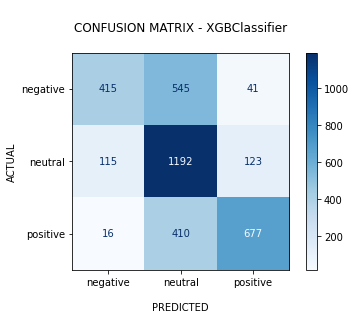

In [ ]:
data = confusion_matrix(test["sentiment"], prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.ylabel("ACTUAL")
plt.xlabel("\nPREDICTED")
plt.title(f"\nCONFUSION MATRIX - {model_name}}\n");
plt.show()

**Hypertuning the model parameters**

In [ ]:
param_grid = {"kernel": ("linear", "rbf","poly") , 
              "C":[5, 10, 90],
              "gamma": [1,0.1,0.01,0.001], 
              "degree": [2,3,4,5,6]}

In [ ]:
random_search = RandomizedSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 3)
random_search.fit(train_vectors, train["sentiment"])

In [ ]:
print(random_search.best_params_)

In [ ]:
print(random_search.best_estimator_)

In [ ]:
print(random_search.best_score_)

**Evaluating the model with best parameters**

In [ ]:
random_predictions = random_search.best_estimator_.predict(train_vectors)
print(accuracy_score(train["sentiment"], random_predictions))

In [ ]:
mse = mean_squared_error(train["sentiment"], random_predictions)
print(np.sqrt(mse))

In [ ]:
random_predictions = random_search.best_estimator_.predict(test_vectors)
print(accuracy_score(test["sentiment"], random_predictions))

In [ ]:
mse = mean_squared_error(test["sentiment"], random_predictions)
print(np.sqrt(mse))

In [ ]:
print(confusion_matrix(test["sentiment"], random_predictions))

In [ ]:
print(classification_report(test["sentiment"], random_predictions))